# Packages

In [66]:
import pandas as pd
import duckdb as db
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

In [26]:
import os
print(os.getcwd())

/Users/gaberiedel/baseball_projects/SMT_2025/analysis_code


# Steal Plays

In [ ]:
with db.connect("smt_2025.db") as con:
    players_on_first = con.sql("""SELECT DISTINCT first_baserunner AS player_name FROM game_info""").df()
    plays_on_first = con.sql("""SELECT COUNT(*) count_on_first, first_baserunner AS player_name FROM game_info 
                                WHERE first_baserunner != 'NA' AND second_baserunner = 'NA' 
                                    AND third_baserunner = 'NA'
                                GROUP BY first_baserunner
                                ORDER BY COUNT(*) DESC""").df()
    
    steal_plays = con.sql("""WITH pitches AS (SELECT * FROM 
                            (SELECT *, 
                            LEAD(event_code) OVER (PARTITION BY game_str, play_per_game ORDER BY timestamp, event_code) AS next_event
                            FROM game_events) subquery
                            WHERE event_code = 1 AND next_event = 2
                            ORDER BY game_str, play_per_game),
                          
                          runner_info AS (SELECT * FROM 
                            (SELECT *, LEAD(first_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_first_base,
                                    LEAD(second_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_second_base,
                                    LEAD(third_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_third_base
                            FROM game_info) subquery
                            WHERE first_baserunner != 'NA' AND next_second_base != 'NA' AND second_baserunner = 'NA' AND third_baserunner = 'NA'
                              AND next_first_base = 'NA' AND next_third_base = 'NA'
                            ORDER BY game_str, play_per_game  )
                          
                          SELECT COUNT(*) stolen_bases, next_second_base AS player_name FROM
                            (SELECT pi.game_str, play_id, pi.play_per_game, player_position, event_code, next_event, pi.home_team, first_baserunner, second_baserunner, next_second_base FROM pitches pi
                            INNER JOIN runner_info ri
                            ON pi.game_str = ri.game_str AND pi.play_per_game = ri.play_per_game) subquery
                          GROUP BY next_second_base
                          ORDER BY COUNT(*) DESC""").df()
  

,game_str,play_id,play_per_game,player_position,event_code,next_event,home_team,first_baserunner,second_baserunner,next_second_base
0,y2_d068_RDO_RZQ,77,77,1,1,2,RZQ,RDO-1507,NA,RDO-1507
1,y2_d069_RDO_RZQ,250,250,1,1,2,RZQ,RDO-1818,NA,RDO-1818
2,y2_d070_RDO_RZQ,198,198,1,1,2,RZQ,RZQ-0310,NA,RZQ-0310
3,y2_d071_XFE_RZQ,146,146,1,1,2,RZQ,RZQ-0310,NA,RZQ-0310
4,y2_d072_XFE_RZQ,273,273,1,1,2,RZQ,XFE-2568,NA,XFE-2568
...,...,...,...,...,...,...,...,...,...,...
282,y1_d059_JNJ_QEA,110,110,1,1,2,QEA,QEA-0364,NA,QEA-0364
283,y1_d059_JNJ_QEA,168,168,1,1,2,QEA,JNJ-1825,NA,JNJ-1825
284,y1_d058_WZR_YJD,306,306,1,1,2,YJD,YJD-0312,NA,YJD-0312
285,y1_d061_HCI_RZQ,139,139,1,1,2,RZQ,RZQ-0381,NA,RZQ-0059


In [255]:
df_runners = pd.merge(players_on_first, plays_on_first, on = "player_name", how = "left")
df_runners

,player_name,count_on_first
0,BEJ-1989,5.0
1,DMS-2426,13.0
2,QEA-0027,101.0
3,QEA-0071,60.0
4,ACN-1147,5.0
...,...,...
893,VHS-1235,6.0
894,VMN-2063,4.0
895,VZE-2346,10.0
896,VZE-1476,9.0


In [262]:
df_runners = pd.merge(players_on_first, plays_on_first, on = "player_name", how = "left")
df_thieves = pd.merge(df_runners, steal_plays, on="player_name", how="left").fillna(0).sort_values(by="stolen_bases", ascending=False)
df_thieves["steal_score"] = (df_thieves["stolen_bases"]/df_thieves["count_on_first"] * np.log(df_thieves["stolen_bases"])).fillna(0)
df_thieves.sort_values(by="steal_score", ascending=False)

/Users/gaberiedel/baseball_projects/SMT_2025/venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log


,player_name,count_on_first,stolen_bases,steal_score
670,BEJ-1854,3.0,3.0,1.098612
802,WZR-1942,4.0,2.0,0.346574
358,OWH-1692,15.0,3.0,0.219722
228,RZQ-0310,143.0,11.0,0.184453
410,IAQ-1783,31.0,4.0,0.178877
...,...,...,...,...
586,HKR-1615,6.0,0.0,0.000000
62,UKI-1501,3.0,0.0,0.000000
589,HMN-1212,11.0,0.0,0.000000
58,TSZ-2189,20.0,0.0,0.000000


# Pickoff plays

In [159]:
with db.connect("smt_2025.db") as con:
    df_pickoff_plays = con.sql("""
                               WITH first_base_player_pos AS (SELECT game_str, play_id, timestamp, player_position AS runner, field_x, field_y
                                FROM(
                                    SELECT *, DENSE_RANK() OVER (PARTITION BY game_str, play_id ORDER BY timestamp) as time_order
                                    FROM player_pos 
                                    WHERE player_position = 11
                                    ORDER BY game_str, play_id, timestamp) sub1
                                    WHERE time_order = 1)
                               SELECT * 
                               FROM game_events ge
                               LEFT JOIN game_info gi 
                               ON ge.game_str = gi.game_str AND ge.play_per_game = gi.play_per_game
                               INNER JOIN first_base_player_pos fb
                               ON ge.game_str = fb.game_str AND ge.play_id = fb.play_id
                               WHERE player_position = 1 AND event_code = 6 
                                AND second_baserunner = 'NA' AND third_baserunner = 'NA' """).df()
    
df_pickoff_plays.to_csv("pickoff_plays.csv")

In [ ]:
with db.connect("smt_2025.db") as con:
    df_pickoff_counts = con.sql("""SELECT COUNT(*) AS pickoffs, pitcher
                          FROM
                          (SELECT * FROM game_events ge
                          LEFT JOIN game_info gi
                          ON ge.game_str = gi.game_str AND ge.play_per_game = gi.play_per_game
                          WHERE event_code = 6) subquery
                          GROUP BY pitcher
                          ORDER BY COUNT(*) DESC;""").df()
    df_pitches_thrown = con.sql("""SELECT COUNT(*) AS pitches, pitcher
                                  FROM game_info
                                  GROUP BY pitcher
                                  ORDER BY COUNT(*) DESC;""").df()
    
df_pitchers = pd.merge(df_pitches_thrown, df_pickoff_counts, on="pitcher", how = "left")
df_pitchers["pickoffs"] = df_pitchers["pickoffs"].fillna(0)
df_pitchers = df_pitchers[df_pitchers["pitches"] > 20]
df_pitchers


,pitches,pitcher,pickoffs
0,1918,YJD-0420,42.0
1,1257,RZQ-0324,21.0
2,1160,YJD-0293,24.0
3,920,RZQ-0082,16.0
4,856,YJD-0335,17.0
...,...,...,...
656,21,PHS-1677,0.0
657,21,TSZ-1746,1.0
658,21,HCI-2467,0.0
659,21,ESW-2385,0.0


In [281]:
with db.connect("smt_2025.db") as con:    
    df_first_runner = con.sql("""SELECT * 
                              FROM player_pos pp
                              LEFT JOIN game_events ge
                              ON pp.game_str = ge.game_str AND pp.play_id = ge.play_id
                              WHERE pp.player_position = 11
                              LIMIT 100;""").df()
df_first_runner

,game_str,play_id,timestamp,player_position,field_x,field_y,home_team,away_team,year,day,...,play_id_1,at_bat,play_per_game,timestamp_1,player_position_1,event_code,home_team_1,away_team_1,year_1,day_1
0,y1_d069_ACN_QEA,7,156603,11,56.4582,70.7073,QEA,ACN,year_1,day_069,...,7,\N,7,160103,0,5,QEA,ACN,year_1,day_069
1,y1_d069_ACN_QEA,7,156653,11,56.4012,70.8111,QEA,ACN,year_1,day_069,...,7,\N,7,160103,0,5,QEA,ACN,year_1,day_069
2,y1_d069_ACN_QEA,7,156703,11,56.3442,70.9146,QEA,ACN,year_1,day_069,...,7,\N,7,160103,0,5,QEA,ACN,year_1,day_069
3,y1_d069_ACN_QEA,7,156753,11,56.2875,71.0181,QEA,ACN,year_1,day_069,...,7,\N,7,160103,0,5,QEA,ACN,year_1,day_069
4,y1_d069_ACN_QEA,7,156803,11,56.2308,71.1216,QEA,ACN,year_1,day_069,...,7,\N,7,160103,0,5,QEA,ACN,year_1,day_069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,y1_d069_ACN_QEA,8,179003,11,56.0973,72.0201,QEA,ACN,year_1,day_069,...,8,\N,8,181303,0,5,QEA,ACN,year_1,day_069
96,y1_d069_ACN_QEA,8,179053,11,56.0892,72.0135,QEA,ACN,year_1,day_069,...,8,\N,8,181303,0,5,QEA,ACN,year_1,day_069
97,y1_d069_ACN_QEA,8,179103,11,56.0811,72.0069,QEA,ACN,year_1,day_069,...,8,\N,8,181303,0,5,QEA,ACN,year_1,day_069
98,y1_d069_ACN_QEA,8,179153,11,56.0733,72.0003,QEA,ACN,year_1,day_069,...,8,\N,8,181303,0,5,QEA,ACN,year_1,day_069


# Pitcher Handedness

In [57]:
with db.connect("smt_2025.db") as con:
    df_pitchers = con.sql("""SELECT DISTINCT pitcher FROM game_info""").df()
    df_pitcher_hand = con.sql("""WITH rp AS 
                         (SELECT * FROM
                         (SELECT ball_position_x, play_id, game_str,
                         DENSE_RANK() OVER (PARTITION BY game_str, play_id ORDER BY timestamp) AS rank
                         FROM ball_pos bp) AS subquery
                         WHERE rank = 1), 

                         pitcher_rp AS (
                         SELECT rp.game_str, rp.ball_position_x, pitcher 
                         FROM rp
                         LEFT JOIN game_info gi
                         ON rp.game_str = gi.game_str AND rp.play_id = gi.play_per_game)
                         
                         SELECT AVG(ball_position_x) avg_rel_point, pitcher FROM pitcher_rp
                         GROUP BY pitcher;""").df()

df_pitcher_hand["hand"] = np.where(df_pitcher_hand["avg_rel_point"] > 0, "L", "R")
df_pitcher_hand


,avg_rel_point,pitcher,hand
0,0.245220,CGA-2438,L
1,-1.878897,JJS-1534,R
2,-1.580158,JJS-1324,R
3,0.571597,JJS-2460,L
4,-0.048428,CGA-1686,R
...,...,...,...
880,-2.696032,MGJ-1969,R
881,1.477698,RZQ-0321,L
882,-1.692663,UEX-1660,R
883,-2.444119,NYA-1027,R


In [142]:
df_pitchers = pd.merge(df_pitchers, df_pitcher_hand, on='pitcher', how='left')
df_pitchers


,pitches,pitcher,pickoffs,avg_rel_point,hand
0,1918,YJD-0420,42.0,-1.365434,R
1,1257,RZQ-0324,21.0,-1.576965,R
2,1160,YJD-0293,24.0,-1.250824,R
3,920,RZQ-0082,16.0,-0.992271,R
4,856,YJD-0335,17.0,1.639872,L
...,...,...,...,...,...
656,21,PHS-1677,0.0,-2.801928,R
657,21,TSZ-1746,1.0,3.734364,L
658,21,HCI-2467,0.0,-1.479193,R
659,21,ESW-2385,0.0,2.548621,L


Text(0, 0.5, 'Frequency')

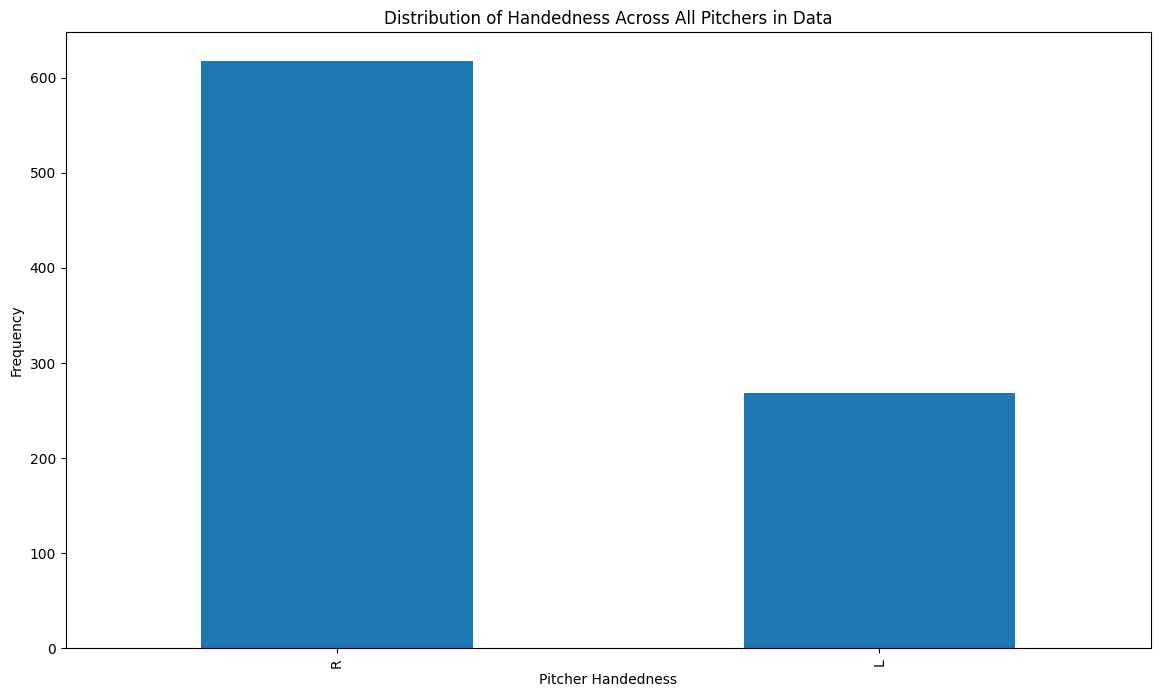

In [58]:
ax = df_pitcher_hand['hand'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Handedness Across All Pitchers in Data")
ax.set_xlabel("Pitcher Handedness")
ax.set_ylabel("Frequency")

# Batter Handedness

In [74]:
with db.connect("smt_2025.db") as con:
    df_batters = con.sql("""SELECT DISTINCT batter FROM game_info""").df()
    df_batter_hand = con.sql("""WITH bh AS 
                         (SELECT * FROM
                         (SELECT field_x, play_id, game_str,
                         DENSE_RANK() OVER (PARTITION BY game_str, play_id ORDER BY timestamp) AS rank
                         FROM player_pos pp
                         WHERE player_position = 10) AS subquery
                         WHERE rank = 1),
                             
                         batter_rp AS (
                         SELECT bh.game_str, bh.field_x, batter 
                         FROM bh
                         LEFT JOIN game_info gi
                         ON bh.game_str = gi.game_str AND bh.play_id = gi.play_per_game)
                             
                         SELECT AVG(field_x) avg_stance, batter FROM batter_rp
                         GROUP BY batter""").df()
    
    

df_batter_hand["hand"] = np.where(df_batter_hand["avg_stance"] > 0, "L", "R")
df_batter_hand


,avg_stance,batter,hand
0,1.524177,HKR-1484,L
1,2.668513,RZQ-0318,L
2,-2.616589,RDO-1507,R
3,-2.857912,DYE-0255,R
4,-2.661000,VZE-1476,R
...,...,...,...
1034,1.732650,XAX-1923,L
1035,-3.082560,DYE-0063,R
1036,-2.791575,YJD-0033,R
1037,-2.653457,POW-1664,R


/Users/gaberiedel/baseball_projects/SMT_2025/venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.


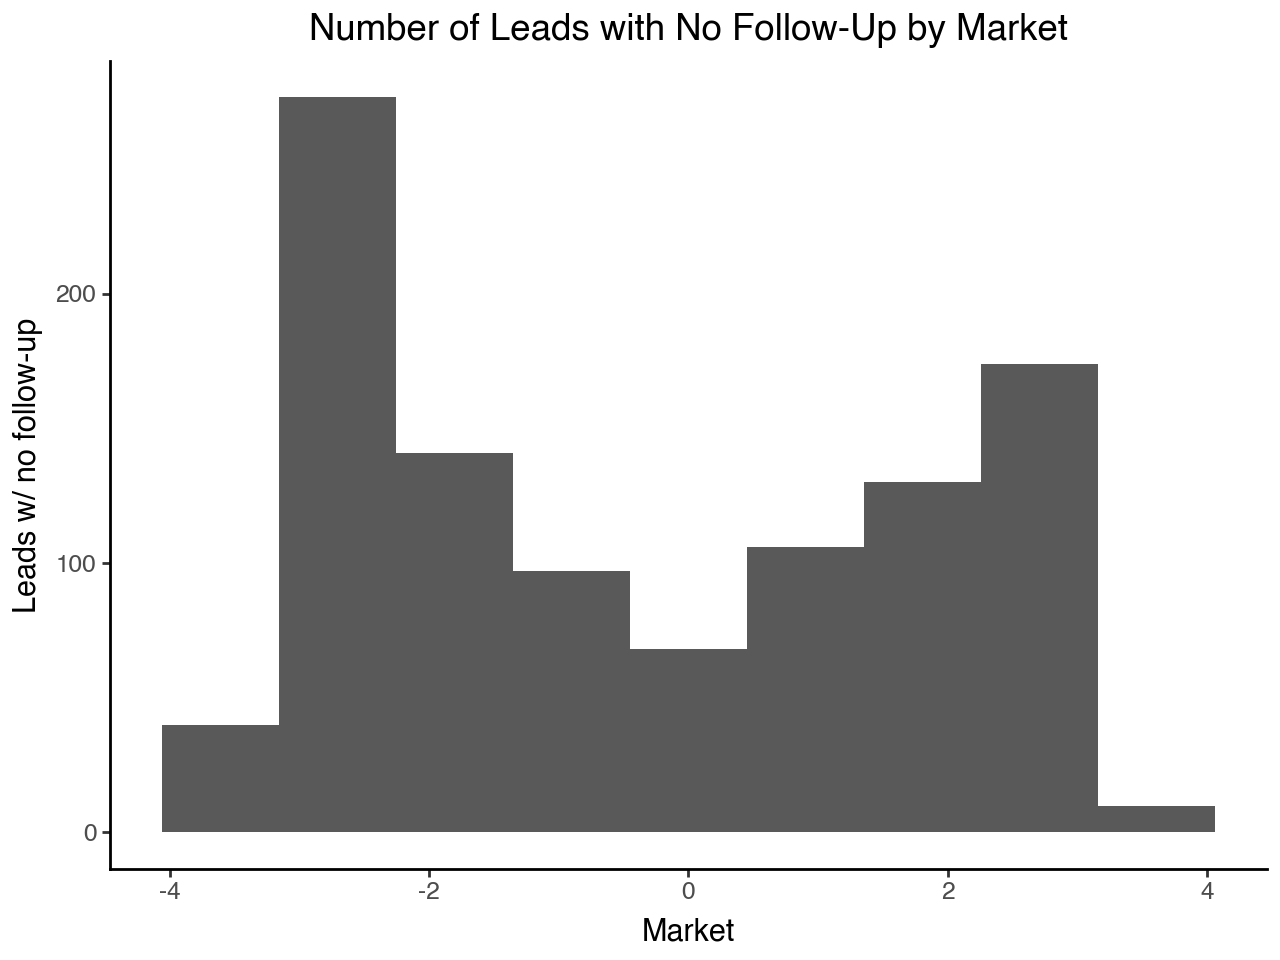

In [71]:
ggplot(df_batter_hand, aes(x='avg_stance')) \
+ geom_histogram() \
+ labs(title = "Number of Leads with No Follow-Up by Market",
       x="Market",
       y="Leads w/ no follow-up") \
+ theme_classic()

Text(0, 0.5, 'Frequency')

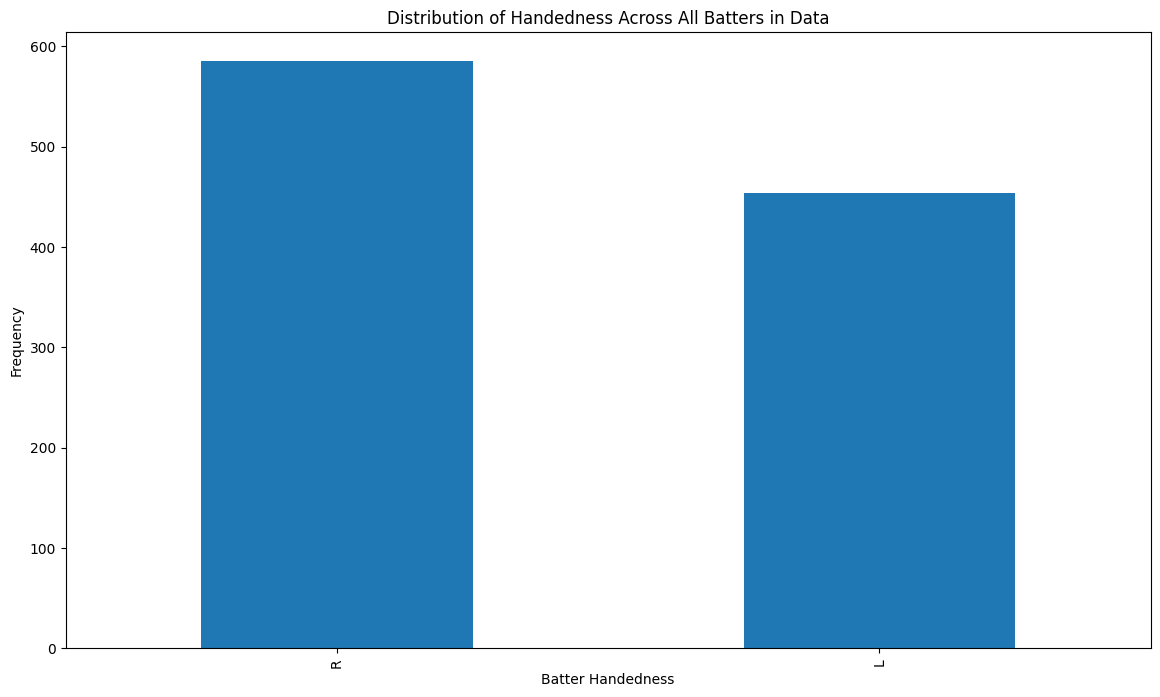

In [75]:
ax = df_batter_hand['hand'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Handedness Across All Batters in Data")
ax.set_xlabel("Batter Handedness")
ax.set_ylabel("Frequency")

# Runs

In [109]:
with db.connect("smt_2025.db") as con:
    df_runs = con.sql("""
                      SELECT game_str, play_per_game, first_baserunner, second_baserunner, third_baserunner,
                      prev_first, prev_second, prev_third
                      FROM 
                      (SELECT *, LAG(first_baserunner) OVER (ORDER BY play_per_game, top_bottom_inning) AS prev_first ,
                      LAG(second_baserunner) OVER (ORDER BY play_per_game, top_bottom_inning) AS prev_second,
                      LAG(third_baserunner) OVER (ORDER BY play_per_game, top_bottom_inning) AS prev_third 
                      FROM game_info) subquery
                      WHERE (prev_first != first_baserunner AND prev_first != second_baserunner AND prev_first != third_baserunner)
                      OR (prev_second != second_baserunner AND prev_second != third_baserunner)
                      OR (prev_third != third_baserunner)
                      """).df()
    df_runs_per_play = con.sql(""" 
                      SELECT play_id, game_str, SUM(run) As runs FROM
                      (SELECT DISTINCT play_id, game_str, 
                      CASE 
                        WHEN (player_position = 11 AND abs(field_x) < 1 AND abs(field_y) < 1) THEN 1 
                        ELSE 0
                      END AS run
                      FROM player_pos
                      UNION ALL
                      SELECT DISTINCT play_id, game_str, 
                      CASE 
                        WHEN (player_position = 12 AND abs(field_x) < 1 AND abs(field_y) < 1) THEN 1 
                        ELSE 0
                      END AS run
                      FROM player_pos
                      UNION ALL
                      SELECT DISTINCT play_id, game_str, 
                      CASE 
                        WHEN (player_position = 13 AND abs(field_x) < 1 AND abs(field_y) < 1) THEN 1 
                        ELSE 0
                      END AS run
                      FROM player_pos) subquery
                      GROUP BY game_str, play_id""").df()
    
df_runs_per_play["runs"].value_counts()

runs
0.0    78502
1.0     1132
2.0      111
3.0       10
Name: count, dtype: int64

In [115]:
df_runs_per_play[df_runs_per_play["runs"] == 3]

,play_id,game_str,runs
14121,57,y2_d036_UKI_RZQ,3.0
26059,249,y1_d030_CMS_YJD,3.0
33265,21,y2_d033_KNB_YJD,3.0
33739,148,y2_d099_YJD_RZQ,3.0
40593,108,y1_d001_CGA_QEA,3.0
44580,114,y1_d050_JZK_RZQ,3.0
45031,52,y1_d012_IXC_QEA,3.0
52532,55,y1_d096_WNA_RZQ,3.0
53856,248,y1_d064_IAQ_YJD,3.0
75152,92,y1_d007_MCJ_RZQ,3.0


In [118]:
with db.connect("smt_2025.db") as con:
    df_grandslams = con.sql("""SELECT * FROM game_events ge
                            LEFT JOIN game_info gi 
                            ON ge.game_str = gi.game_str AND ge.play_per_game = gi.play_per_game
                            LEFT JOIN player_pos pp
                            ON pp.game_str = gi.game_str AND pp.play_id = gi.play_per_game
                            WHERE ge.event_code = 11 AND gi.first_baserunner != 'NA' AND gi.second_baserunner != 'NA'
                            AND gi.third_baserunner != 'NA' AND pp.player_position = 10""").df()

df_grandslams

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,year,...,game_str_2,play_id_1,timestamp_1,player_position_1,field_x,field_y,home_team_2,away_team_2,year_2,day_2
0,y1_d027_JIL_RZQ,389,95,389,13414659,255,11,RZQ,JIL,year_1,...,y1_d027_JIL_RZQ,389,13410659,10,-2.6577,-1.6575,RZQ,JIL,year_1,day_027
1,y1_d027_JIL_RZQ,389,95,389,13414659,255,11,RZQ,JIL,year_1,...,y1_d027_JIL_RZQ,389,13410709,10,-2.7240,-1.5438,RZQ,JIL,year_1,day_027
2,y1_d027_JIL_RZQ,389,95,389,13414659,255,11,RZQ,JIL,year_1,...,y1_d027_JIL_RZQ,389,13410759,10,-2.8071,-1.4445,RZQ,JIL,year_1,day_027
3,y1_d027_JIL_RZQ,389,95,389,13414659,255,11,RZQ,JIL,year_1,...,y1_d027_JIL_RZQ,389,13410809,10,-2.8959,-1.3494,RZQ,JIL,year_1,day_027
4,y1_d027_JIL_RZQ,389,95,389,13414659,255,11,RZQ,JIL,year_1,...,y1_d027_JIL_RZQ,389,13410859,10,-2.9847,-1.2570,RZQ,JIL,year_1,day_027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,y1_d086_CRQ_QEA,119,29,119,4581232,255,11,QEA,CRQ,year_1,...,y1_d086_CRQ_QEA,119,4575483,10,-2.2254,0.1869,QEA,CRQ,year_1,day_086
602,y1_d086_CRQ_QEA,119,29,119,4581232,255,11,QEA,CRQ,year_1,...,y1_d086_CRQ_QEA,119,4575533,10,-2.2182,0.1848,QEA,CRQ,year_1,day_086
603,y1_d086_CRQ_QEA,119,29,119,4581232,255,11,QEA,CRQ,year_1,...,y1_d086_CRQ_QEA,119,4581683,10,49.4607,37.1589,QEA,CRQ,year_1,day_086
604,y1_d086_CRQ_QEA,119,29,119,4581232,255,11,QEA,CRQ,year_1,...,y1_d086_CRQ_QEA,119,4581733,10,49.9857,37.8168,QEA,CRQ,year_1,day_086


In [121]:
with db.connect("smt_2025.db") as con:
    df_trot = con.sql("""SELECT DISTINCT game_str FROM game_info""").df()
    
df_trot

,game_str
0,y1_d003_CGA_QEA
1,y1_d018_OXG_QEA
2,y1_d050.5_STK_QEA
3,y2_d012_BVD_RZQ
4,y2_d013_BVD_RZQ
...,...
269,y2_d054_PTB_YJD
270,y2_d012_RQJ_YJD
271,y2_d044_RZQ_YJD
272,y1_d047_VHS_YJD


# Outs

In [ ]:
with db.connect("smt_2025.db") as con:
    df_missing_runners = con.sql("""SELECT *, LAG(first_baserunner) OVER ()""")

# Animation

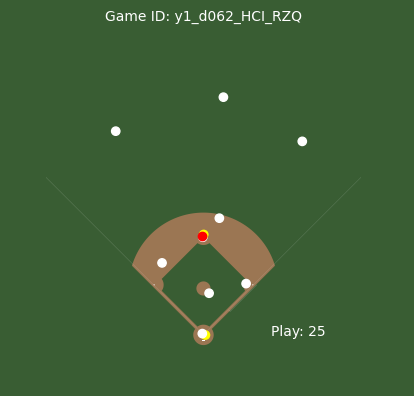

In [278]:
from Animation import plot_animation

with db.connect("smt_2025.db") as con:

    player_position_df = con.sql("""SELECT * FROM player_pos  
                                    WHERE game_str = 'y1_d062_HCI_RZQ'; """).df()
    ball_position_df = con.sql("""SELECT * FROM ball_pos  
                                    WHERE game_str = 'y1_d062_HCI_RZQ'; """).df()

# Animate play
# Arguments are player_pos, ball_pos, play_id, and whether we want to save the animation afterwards
plot_animation(player_position_df, ball_position_df, 25, False)

In [ ]:
def random_play(df):
    random_row = df.sample(n=1)
    with db.connect("smt_2025.db") as con:
            print(random_row["game_str"])
            player_position_df = con.sql(f"""SELECT * FROM player_pos  
                                            WHERE game_str = {random_row["game_str"].astype(str)};""").df()
            ball_position_df = con.sql(f"""SELECT * FROM ball_pos  
                                            WHERE game_str = {random_row["game_str"]};""").df()
            plot_animation(player_position_df, ball_position_df, random_row["play_id"], False)

        
    

In [290]:
random_play(df_first_runner)

82    y1_d069_ACN_QEA
Name: game_str, dtype: object


ParserException: Parser Error: syntax error at or near "y1_d069_ACN_QEA"